# Assignment 9: Final Project
## Computational Methods in Psychology (and Neuroscience)
### Psychology 4500/7559 --- Fall 2020


# Objectives

Upon completion of this assignment, students will have:

1. Described the list generation process in detail
2. Described the experiment details
3. Visualized processed data
4. Performed a statistical analysis to test the hypothesis

# Assignment

Write text (in MarkDown cells) and code (in Code cells) in a Jupyter notebook (after making a copy and renaming it to have your userid in the title --- e.g., A09_Final_Project_mst3k).


## Details

The goal of the final project is to synthesize material covered in the class and produce part of what would go into an actual scientific publication based on *one* of the experiments we ran in the class. Specifically, you will be writing part of the Methods and Results sections.

The basic template is below the code for loading and processing the data. There we outline what each section should include. As always, make sure to label all figures and be sure to refer to the code in the lesson notebooks as a guide for your analyses.

Please feel free to reach out to us on Slack if you have any questions along the way.

* ***When you are done, save this notebook as HTML (`File -> Download as -> HTML`) and upload it to the matching assignment on UVACollab.***  

## General Imports

In [101]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn 
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os

from smile.log import log2dl

from ci_within import ci_within

import statsmodels.formula.api as smf
import statsmodels.api as sm

## Custom SLOG loading function

In [102]:
# custom function to load slogs
def load_all_subj_logs(task_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.split(subj_dir)[-1] 
             for subj_dir in glob(os.path.join(task_dir, 's*'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(task_dir, subj, log_file)
        #print(log_path)

        # load the data
        all_dat.extend(log2dl(log_path, subj=subj))

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [103]:
# load the data from the word recog task
task_dir = os.path.join('..', 'lessons', 'data2', 'Taskapalooza')

df_f = load_all_subj_logs(task_dir, 'log_flanker')
df_i = load_all_subj_logs(task_dir, 'log_image_test')
df_w = load_all_subj_logs(task_dir, 'log_word_test')
df_w.head()

,resp_map_lure,resp_map_target,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,...,valence_sd,arousal_mean,arousal_sd,dominance_mean,dominance_sd,word_frequency,novelty,cond,subj,log_num
0,F,J,0,0,234.395511,0.0,J,235.284833,0.000180,0.889323,...,1.5700000000000001,5.3099999999999996,2.23,5.46,2.0499999999999998,3,target,neu,s001,0
1,F,J,0,1,235.885654,0.0,F,237.034670,0.000182,1.149016,...,1.5,4.1200000000000001,1.8300000000000001,5.6600000000000001,1.78,12,lure,neu,s001,0
2,F,J,0,2,237.616869,0.0,F,238.767406,0.000238,1.150537,...,1.8200000000000001,5.4500000000000002,2.1499999999999999,4.6399999999999997,2.0699999999999998,16,lure,neu,s001,0
3,F,J,0,3,239.624933,0.0,F,240.432295,0.000182,0.807362,...,1.24,3.9500000000000002,2.5800000000000001,5.3700000000000001,1.6399999999999999,19,lure,neu,s001,0
4,F,J,0,4,241.432209,0.0,F,242.545227,0.000192,1.113017,...,2.1600000000000001,3.6800000000000002,2.5699999999999998,5.8300000000000001,1.5,49,lure,neu,s001,0


## Some data clean-up

In [104]:
# it turns out the cond is easier to visualize as pure and mixed
def fix_conds(df, type_col):
    # loop over the unique subjects
    usubj = df.subj.unique()
    for s in usubj:
        # loop over their blocks
        ublocks = df.loc[df['subj']==s, 'block_num'].unique()
        for b in ublocks:
            # grab the data for that subj and block
            dfb = df.loc[(df['subj']==s)&(df['block_num']==b)]
            
            # get the unique types in that block
            uval = dfb[type_col].unique()
            if len(uval) > 1:
                # it's mixed
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'mixed'
            else:
                # it's the pure
                df.loc[(df['subj']==s)&(df.block_num==b), 'cond'] = 'pure'

# fix the conds in the recog experiments (updated in place)
fix_conds(df_i, type_col='in_out')
fix_conds(df_w, type_col='valence')

# add in log_rt columns
df_f['log_rt'] = np.log(df_f['rt'])
df_i['log_rt'] = np.log(df_i['rt'])
df_w['log_rt'] = np.log(df_w['rt'])

# must make correct an int
df_f['correct'] = df_f['correct'].astype(np.int)
df_i['correct'] = df_i['correct'].astype(np.int)
df_w['correct'] = df_w['correct'].astype(np.int)

# add in a column for whether they made an 'old' response
df_i['old_resp'] = (df_i['resp_map_target'] == df_i['resp']).astype(np.int)
df_w['old_resp'] = (df_w['resp_map_target'] == df_w['resp']).astype(np.int)

# process some of the valence info
df_w['valence_mean'] = df_w['valence_mean'].astype(np.float)
df_w['arousal_mean'] = df_w['arousal_mean'].astype(np.float)
df_w['dominance_mean'] = df_w['dominance_mean'].astype(np.float)
df_w['abs_valence'] = np.abs(df_w['valence_mean'] - 5.0)
df_w['abs_arousal'] = np.abs(df_w['arousal_mean'] - 5.0)

# Hypothesis

The hypothesis of this experiment is the following:

 **There is an effect of valence and correctness (potentially interacting with condition) on response times.**

# Methods



## List generation


### Objective

The goal of the List Generation procedure is to create usable test and study lists that can be presented to participants in the Memory Recognition task below. The inputs of this procedure are pools of stimuli split up by valence and the output is a list of blocks containing study and test list pairs of stimuli. 


### Requirements and Data

This List Generation procedure uses imported python libraries such as `csv` to read in the pools of stimuli that are split up by valence. 

The primary pools of data used were contained in the following three CSV files:
- [Positive Pool](./pos_pool.csv)
- [Negative Pool](./neg_pool.csv)
- [Neutral Pool](./neu_pool.csv)

The underlying Memory Recognition task is set up as a study-test design with two primary conditions: `pure` and `mixed`. The pure condition contains study and test lists of the same valence: either `positive`, `negative` or `neutral` valences. The mixed condition contains study and test lists with varying valences. 

Important requirements for the lists are as follows:
1. All study lists for both `pure` and `mixed` block conditions should have an equal number of words
2. All test lists for both `pure` and `mixed` block conditions should have an equal number of words
3. There should be an equal number of `positive`, `negative` or `neutral` valenced words in both the study and test lists of the mixed condition blocks. 
4. There should be no repeated words across the blocks of the experiment


### Design 

To produce the appropriate data for this experiment, the List Generation procedure builds the experimental blocks from the bottom-up, starting with individual study and test words. Individual words were stored such that all the relevant information of the particular stimulus including its novelty, condition and valence were saved as well. For this particular procedure we utilized a python dictionary to accomplish this, but any similar data structure would do.  


These dictionaries are then grouped into into study and test lists that are further grouped into study and test list pairs representing blocks. **Note: each block was a pair containing a study list and a test list**. Because the Memory Recognition task requires an equal number of positive pure, negative pure, neutral pure and mixed blocks, blocks are added to the `blocks` list in increments of 4 (1 for each block type). `blocks` was the finalized list and output for this procedure



### Procedure 

Once the data pools are read in, the appropriate configuration variables are set up including the number of pools(or valences), number of items per pure list, and number of repetitions for each block type. 

Another important variable is the number of items per valence in the mixed list. This should be set equal to number of items per pure list divided by the number of pools. This is done to ensure that every type of block has eqiuivalent list sizes. It is thus crucial to make sure that our number of items per pure list is configured so that it is divisible by the number of pools. For this experiment, 3 pools were used (positive, negative and neutral), the number of items per pure list was 24 and the number of repeitions for each block type was 2. Because we have 4 types of blocks (positive pure, negative pure, neutral pure and mixed blocks) our experiment had 8 blocks total. 

Once the configuration variables were set up appropriately, the data pools for each valence were taken in as lists and a valence attribute was added to each element in the respective valence pools to signify whether they were positive, negative or neutral. The blocks were subsequently shuffled to maintain randomization. 

Then, using a dedicated block generation function and the number of repetitions per block type (2 in this case), the 8 blocks of the experiment were created. The block generation function took in a list of pools, a valence, and a number of items. For the pure lists, only one pool assosiated with the valence was passed in and the number of items passed in was the pre-configured number of items per pure list. For the mixed lists, all three pools were passed in and the number of items passed in was the pre-configured number of items per mixed list. 

Using the passed in parameters, the block generation function looped through the provided pools (note: mixed lists had 3x more iterations to accomodate for the smaller number of items passed in) and created **indiviual dictionaries for every study item**, using the data from the given pools and storing relevant information such as the item's condition, novelty and valence. These study word dictionaries were then added to a study list containing all the study words for the particular block. Once every study word was added, the list was shuffled to maintain randomization. 

The test list for a particular block was created by creating a copy of the study list, and looping through the pools of data again to add an equivalent number of new words (lures). The test list was shuffled at the end to maintain randomization. 

Finally, the block generation function returned a dictionary containing both the study and test lists. This is was repeated over the number of required blocks (8 blocks total with 2 of each block type), and the final output was shuffled to maintain inter-block randomization. 



## SMILE Experiment Details

### Objective

This Memory Recognition task utilizes the lists generated by code from the list generation procedure above to create an experiment for collecting the desired data. For this Recognition Memory task, participants will study a list of items one at a time, and then, after a short math distractor, wil be tested for their memory of those items. 


### Requirements and Data

The Recognition Memory task was created using an open-source, Python-based experient bulding library: State Machine Interface Library for Experiments (SMILE; https://github.com/compmem/smile). Subjects completed the task on their local computers that were capable of running the provided experiments. 


All data imported for the study and test lists are taken from the "List Generation" procedure above. The required study and test lists are taken in as a variable `blocks` which represents the blocks of trials of this experiment. 


    
### Design 

The Recognition Memory task utilizes a study-test design with two primary conditions: pure and mixed. The pure condition contains study and test words of the same valence: either positive, negative or neutral valences. The mixed condition contains study and test words of varying valences. 

On each trial, subjects were presented with a list of study words and were tested on a matching list of test words that contained the study words (targets) and a set of new unstudied words (lures). In between the study and test phases, subjects were given a short (set time) math distractor in which they signified whether a presented math equation was valid or invalid by pressing the "F" key for valid equations and "J" key for invalid equations. In the testing phase, subjects were asked to make a decision on whether thay had studied the presented words by pressing either the "F" key for targets or the "J" key for lures. 

Subjects completed 8 blocks, consiting of 24 study words and 48 test words each. There were 4 primary block types and there were an equal number (2 each) of each block type: positive pure, negative pure, neutral pure and mixed. 


### Procedure

After inputing their subject id information, subjects were presented with a brief instruction screen for the experiment. The instructions contained information about the Memory Recognition task, introducing the study phase, testing phase and the 30 seconds of math problems in between them. After the subjects clicked through the instruction screen, they were taken to the start of the first block.

At the start of a block, the subjects are taken to a pre-study-phase screen prompting the users to hit the "ENTER" key prior to beginning the study phase. Every study phase started with a pre-configured delay time including a jitter. Within the study phase itself, each item is presented for 1s and after each study item was presented, there was an inter stimulus delay (default was 0.5s) along with a randomized jitter (random value up to 0.5s)

Following the study phase, the subjects were taken to an instruction screen for the math portion of the block, which included a prompt for the users to hit the "ENTER" key prior to beginning the math portion. 

Finally, after the math portion of the block, subjects were taken to an instruction screen for the testing phase of the block, including a prompt for the users to hit the "ENTER" key prior to beginning the testing phase. 


During the testing phase, subjects were presented with a stimulus that was either a studied item (target) or a new item (lure). Using the designated response keys, "F" for targets, "J" for lures, subjects made decisions on whether they had studied the presented words. After each test item was presented and responded to, there was an inter stimulus delay (default was 0.5s) along with a randomized jitter (random value up to 0.5s)


Upon completion of the testing phase, the next block starts in the same way, and the cycle is repeated until all the blocks are finished. 


# Results

## Primary Question: 
Is there an effect of valence (potentially interacting with condition) and correctness on response times?

## Motivations 
Before running this analysis, I first want to introduce the motivations for this hypothesis. Thinking about the nature of the recognition memory test, there is some reason to believe that people process different words at different rates. Particularly, positive, negative and neutral words may be percieved diffently based on one's personal experiences and could subsequently be processed differently. Additionally, there is reason to believe that incorrect responses had longer response times bcause the individual was potentially unsure of their response. 
Though causality can never be guaranteed in either of these cases, this analysis looks to see if there is some tangible effects in the data. From there, further analyses can be run to find more conclsive findings. 

## Important Variables
In this analysis, the dependent variable will be `log_rt` instead of `rt` because logarithmic values are easier to analyze and interpret when using statistical analyses. For the independent variables, we will use `valence` and `correct`. 

## Data processing and visualization


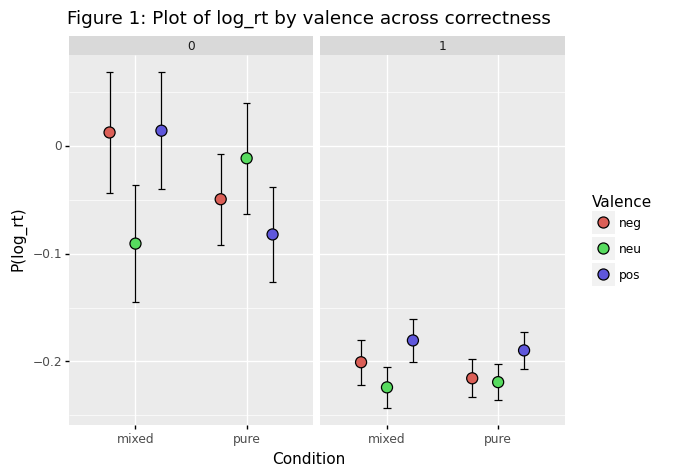

<ggplot: (7012048969)>

In [112]:
# creating the right dataframe to plot and visualize the problem stated above
# get the error corrected by condition and whether they answered correctly
res = ci_within(df_w,  
                indexvar='subj',       # column that identifies a subject
                withinvars=['cond', 'correct', 'valence'],     # list of columns for grouping within subject
                measvar='log_rt')        # dependent variable averaging over

res = res.reset_index()

p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='valence'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.7))
     + pn.geom_point(position=pn.position_dodge(.7), size=4)
     + pn.facet_wrap('~ correct')
     + pn.labs(title="Figure 1: Plot of log_rt by valence across correctness", x="Condition", y = "P(log_rt)", fill='Valence')
    )
p

In the figure above, we can see a plot of `log_rt` as a function of valence. The plot is split into correct and incorrect responses (labeled by the `1` and `0` at the top of each plot respectively). Furthermore, to account for differences in condition, two sets of plots (`mixed` and `pure`) were included for each valence and corectness. 

## Statistical test and interpretation

In [94]:
# Code for statistical test using statsmodel

# use the agg method to get the means
perf = df_w.groupby(['subj', 'cond', 'valence', 'correct'])['log_rt'].mean()
perf = perf.reset_index()
perf

,subj,cond,valence,correct,log_rt
0,s001,mixed,neg,0,0.167138
1,s001,mixed,neg,1,-0.217212
2,s001,mixed,neu,0,-0.109757
3,s001,mixed,neu,1,-0.215241
4,s001,mixed,pos,0,0.166381
...,...,...,...,...,...
271,s023,pure,neg,1,-0.284881
272,s023,pure,neu,0,-0.249797
273,s023,pure,neu,1,-0.347838
274,s023,pure,pos,0,-0.357336


In [95]:
# build a linear regression of the full model
m0 = smf.ols("log_rt ~ cond * valence * correct", perf).fit()
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_rt   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     4.053
Date:                Wed, 02 Dec 2020   Prob (F-statistic):           1.70e-05
Time:                        22:59:04   Log-Likelihood:                -52.458
No. Observations:                 276   AIC:                             128.9
Df Residuals:                     264   BIC:                             172.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.0358      0.062      0.574      0.566      -0.087       0.159
cond[T.pure]                           -0.0377      0.088     -0.427      0.670      -0.211       0.136
valence[T.neu]                         -0.0979      0.088     -1.110      0.268      -0.272       0.076
valence[T.pos]                          0.0480      0.088      0.544      0.587      -0.126       0.222
cond[T.pure]:valence[T.neu]             0.1971      0.125      1.580      0.115      -0.049       0.443
cond[T.pure]:valence[T.pos]            -0.0671      0.125     -0.538      0.591      -0.313       0.179
correct                                -0.2348      0.088     -2.661      0.008      -0.409      -0.061
cond[T.pure]:correct                    0.0233      0.125      0.186      0.852      -0.222       0.269
valence[T.neu]:correct                  0.0741      0.125      0.594      0.553      -0.172       0.320
valence[T.pos]:correct                 -0.0286      0.125     -0.229      0.819      -0.274       0.217
cond[T.pure]:valence[T.neu]:correct    -0.1750      0.176     -0.992      0.322      -0.522       0.172
cond[T.pure]:valence[T.pos]:correct     0.0680      0.176      0.385      0.700      -0.279       0.415
==============================================================================
Omnibus:                      120.457   Durbin-Watson:                   0.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              535.822
Skew:                           1.794   Prob(JB):                    4.44e-117
Kurtosis:                       8.807   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Running an ANOVA on the linear model results

- The results of such a complicated linear model is hard to unpack
- The most common approach to modeling the data would be a repeated measures ANOVA
- Luckily, a linear regress is effectively just an ANOVA if you make the right comparisons
- To simplify the results of the regression, we will run an ANOVA analysis below

In [111]:
# Run a type-II repeated measures ANOVA based on the linear model results
sm.stats.anova_lm(m0, typ=2)

,sum_sq,df,F,PR(>F)
cond,0.000018,1.0,0.000202,9.886632e-01
valence,0.026583,2.0,0.148474,8.620946e-01
cond:valence,0.256683,2.0,1.433668,2.402830e-01
correct,3.519608,1.0,39.316559,1.463755e-09
cond:correct,0.002658,1.0,0.029688,8.633310e-01
valence:correct,0.004318,2.0,0.024119,9.761714e-01
cond:valence:correct,0.180761,2.0,1.009613,3.657622e-01
Residual,23.633208,264.0,NaN,NaN


# Findings

Starting with the plots presented in Figure 1 above, it is clear that there is a discrepancy in response times for responses across corectness. Specfically, we see that incorrect responses are significantly slower than correct responses: big discrepancies in `log_rt` are obvious in incorrect vs correct plots. 

This is also supported by the results of our linear regression and ANOVA tests which show a significant F value of 39.316559 for corectness. This finding seems to support part of our hypothesis that corecntess has some positive effect on response times (larger response time = slower). This is a very promising finding from our analysis, and with further study, more robust causal effects of correctness on response times may be found. 


However, when looking at the the plots presented in Figure 1 again, there do not seem to be similar significant effects of valence and condition on response times. In the plots, there seem to be very minimal (if any) discrepancies in response times when comapring data across valence and condition. This is also supported in the linear regression and ANOVA results showing very small F values for both condition and valence. This finding seems to go against part of our initial hypothesis that valence and condition may have some effect on response times. Though this is not conlusive, it gives some evidence representing the data points in this experiment. Additional analyes will be required to show a more accurate effect of valence and condition on participants' response times. 


On that note, it is worth noting that though there were no significant findings of valence effects on response times, in the plots in Figure 1, there seemed to be some effect of positive and negative valence vs neutral valence on response times. That is to say that, in the plots, positive and negative valences seemed to have slower response times when compared to neutral valences. This is a very interesting observation, that would require further analysis to verify: perhaps using a linear mixed effects regression will be needed to analyze `abs_valence` to see if this is a valid and significant effect. 

In sum, we have found reason to believe that corectness has some tangible effect on response times based on the data points we observed. Additionally, valence and condition appeared to have no effects on response times based on our analysis. Though there are some promising plots showing some mild effects of `abs_valence` on response times, it is not conclusive enough to determine a statstically significant effect. More study and analyses will be needed to confirm the accuracy of our findings on both correctness and valence (potentially interacting with condition). 
